# Predictive Employee Attrition Model

**Author:** Fabrice Achu Ngando  
**Date:** October 2025  

## Project Description
This notebook implements a **Predictive Employee Attrition Model** using the IBM HR Analytics Employee Attrition dataset (`WA_Fn-UseC_-HR-Employee-Attrition.csv`).  

The goal is to **predict which employees are at high risk of leaving the company**.  

This project demonstrates the full Data Science lifecycle:
- Data loading and cleaning
- Feature engineering
- Handling categorical variables
- Model training with hyperparameter tuning
- Evaluation with multiple metrics
- Feature importance analysis and visualization


## 1. Import Libraries

We start by importing all necessary libraries for:
- Data manipulation (`pandas`, `numpy`)  
- Visualization (`matplotlib`, `seaborn`)  
- Machine learning (`scikit-learn`)  
- Model saving (`joblib`)


In [14]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib


## 2. Data Loading

- Load the IBM HR Analytics dataset.
- Display the number of rows and columns to confirm successful loading.
- Handle the FileNotFoundError gracefully if the CSV is missing.

In [15]:
# 2. Data Loading
try:
    data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print(f"Data loaded successfully. Rows: {data.shape[0]}, Columns: {data.shape[1]}")
except FileNotFoundError:
    print("ERROR: Dataset not found. Download 'WA_Fn-UseC_-HR-Employee-Attrition.csv' "
          "and place it in the same directory as this script.")
    exit()

Data loaded successfully. Rows: 1470, Columns: 35


## 3. Data Cleaning and Feature Engineering

- Drop irrelevant or constant columns: `EmployeeCount`, `StandardHours`, `Over18`.
- Convert the target variable `Attrition` to binary: Yes=1, No=0.
- Check for missing values and fill them if any.
- Create a new feature `Stock_Sal_Ratio` to capture the ratio of stock options to salary.


In [16]:
# 3. Data Cleaning & Feature Engineering
# Drop irrelevant or constant columns
data = data.drop(columns=['EmployeeCount', 'StandardHours', 'Over18'])

# Convert target to binary: Attrition (Yes=1, No=0)
data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Check for missing values
if data.isnull().sum().any():
    print("Missing values detected. Filling with 0 for simplicity.")
    data.fillna(0, inplace=True)

# Feature Engineering: Stock option to salary ratio
data['Stock_Sal_Ratio'] = np.where(
    data['MonthlyIncome'] > 0,
    data['StockOptionLevel'] / data['MonthlyIncome'],
    0
)


## 4. Handling Categorical Variables

- Identify categorical columns (`object` type).
- Apply **one-hot encoding** to convert them into numeric features.
- Drop the first level of each categorical variable to avoid multicollinearity.


In [19]:
# 4. Categorical Encoding
categorical_cols = data.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
print(f"\nData shape after encoding: {data_encoded.shape}")


Data shape after encoding: (1470, 47)


## 5. Define Features (X) and Target (y)

- `X`: All features except `Attrition`.
- `y`: Target variable (`Attrition`) indicating if an employee left the company.


In [20]:
# 5. Define Features and Target
X = data_encoded.drop('Attrition', axis=1)
y = data_encoded['Attrition']

## 6. Train-Test Split

- Split dataset into **70% training** and **30% testing**.
- Use stratified sampling to maintain the proportion of employees who left (`Attrition=1`) in both sets.


In [21]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")



Train set size: 1029, Test set size: 441


## 7. Model Training with Random Forest

- Random Forest Classifier.
- Hyperparameter tuning with `GridSearchCV`.
- Account for class imbalance with `class_weight='balanced'`.


In [22]:
# 7. Model Training
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)
model = grid.best_estimator_
print(f"\nBest Random Forest Model: {model}")



Best Random Forest Model: RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)


## 8. Model Evaluation

- Metrics: Accuracy, ROC-AUC, Confusion Matrix, Classification Report.
- Focus on F1-score for Attrition=1.


In [23]:
# 8. Model Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_prob)
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_score:.4f}")
print("Confusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)



--- Model Evaluation ---
Accuracy: 0.8299
ROC-AUC Score: 0.7590
Confusion Matrix:
[[356  14]
 [ 61  10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       370
           1       0.42      0.14      0.21        71

    accuracy                           0.83       441
   macro avg       0.64      0.55      0.56       441
weighted avg       0.78      0.83      0.79       441



## 9. Feature Importance

- Identify the top 10 features influencing attrition predictions.
- Visualize them for business insights.



--- Top 10 Features Driving Attrition Prediction ---
MonthlyIncome           0.075530
Age                     0.057560
Stock_Sal_Ratio         0.057538
YearsWithCurrManager    0.046604
TotalWorkingYears       0.045392
YearsAtCompany          0.043958
DailyRate               0.043802
OverTime_Yes            0.042927
EmployeeNumber          0.040564
MonthlyRate             0.039962
dtype: float64


C:\Users\achub\AppData\Local\Temp\ipykernel_25980\1752048796.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')


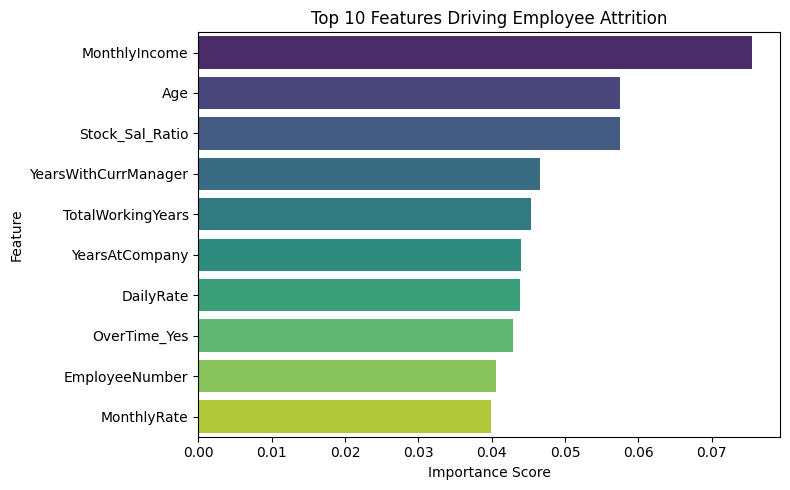

In [24]:
# 9. Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- Top 10 Features Driving Attrition Prediction ---")
print(top_10_features)

# Visualize top features
plt.figure(figsize=(8, 5))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Features Driving Employee Attrition')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 10. Save Trained Model

- Save the trained Random Forest model with `joblib` for future predictions.


In [25]:
# 10. Save Model
joblib.dump(model, 'attrition_model.pkl')
print("\nTrained model saved as 'attrition_model.pkl'")



Trained model saved as 'attrition_model.pkl'


## 11. Conclusion

- The model predicts which employees are at high risk of leaving.
- Key features influencing attrition: `OverTime`, `Stock_Sal_Ratio`, `JobSatisfaction`.
- Demonstrates a complete predictive modeling pipeline for HR analytics:
  - Data preprocessing
  - Feature engineering
  - Model training and tuning
  - Evaluation and interpretation
- HR teams can leverage these insights to improve retention strategies.


In [28]:
# 11. Conclusion
print("\n[END OF SCRIPT]")
print("This pipeline demonstrates predictive modeling for HR analytics, "
      "including feature engineering, training, evaluation, and interpretation.")


[END OF SCRIPT]
This pipeline demonstrates predictive modeling for HR analytics, including feature engineering, training, evaluation, and interpretation.
